<a href="https://colab.research.google.com/github/gaegoori/handsignproject/blob/model/%EA%B8%B0%ED%95%99%EA%B8%B0%EC%A0%84%EC%B2%98%EB%A6%AC_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A6%9D%EA%B0%95_ipynb_%EA%B9%80%EB%8F%99%EC%A7%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Drive 마운트
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%%bash
SRC="/content/drive/MyDrive/keypoints_all"
DST="/content/drive/MyDrive/keypoints_160F"

mkdir -p "$DST"

echo "정확한 WORD0001~0160 + REAL01~16 + F 버전만 추출 시작"

for z in "$SRC"/*.zip; do
    echo "ZIP 처리 중: $z"

    # 정확한 숫자 범위만 포함 (0001~0160)
    for i in $(seq -f "%04g" 1 160); do
        unzip -qq "$z" "*/NIA_SL_WORD${i}_REAL*_F*" -d "$DST"
    done
done

echo "추출 완료"
echo "저장 위치: $DST"

Process is terminated.


In [ ]:
import os
from zipfile import ZipFile

zip_path = "/content/drive/MyDrive/01_real_word_morpheme.zip"   # 네가 업로드한 경로
extract_to = "/content/drive/MyDrive/morpheme_full"

os.makedirs(extract_to, exist_ok=True)

with ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_to)

print("압축해제 완료:", extract_to)

압축해제 완료: /content/drive/MyDrive/morpheme_full


In [ ]:
import os, json, glob
from tqdm import tqdm

# 0. 경로 설정
# Keypoint 폴더의 루트 경로
keypoint_root = "/content/drive/MyDrive/keypoints_160F"
# Morpheme 파일의 루트 경로
morpheme_root = "/content/drive/MyDrive/morpheme_full/morpheme"
# 최종 JSON 파일이 저장될 경로
output_dir = "/content/drive/MyDrive/sign_data/fast_index"

os.makedirs(output_dir, exist_ok=True)

# ============================
# 1. WORD 0001 ~ 0160 자동 생성
# ============================
selected_words = {f"NIA_SL_WORD{str(i).zfill(4)}" for i in range(1, 161)}
print(f"선택된 단어 수: {len(selected_words)}개 (160개면 정상)")


# ============================
# 2. morpheme 파일 로드 및 REAL ID 딕셔너리 생성
# (NIA_SL_WORD0001_REAL02 → 파일 경로)
# ============================
morpheme_files = glob.glob(os.path.join(morpheme_root, "**/*.json"), recursive=True)
morpheme_dict = {}

def extract_real_id_from_morpheme(filename):
    # NIA_SL_WORD0001_REAL02_morpheme.json → NIA_SL_WORD0001_REAL02 추출
    name = os.path.basename(filename).replace("_morpheme.json", "")
    return name.rsplit("_", 1)[0]

for f in tqdm(morpheme_files, desc="Morpheme 파일 로드"):
    real_id = extract_real_id_from_morpheme(f)
    base_word = real_id.split("_REAL")[0] # NIA_SL_WORD0001

    # 선택된 단어에 포함되는 경우에만 딕셔너리에 추가
    if base_word in selected_words:
        # REAL ID를 고유 키로 사용하여 1:1 매칭 준비
        morpheme_dict[real_id] = f

print(f"필터링된 morpheme (REAL ID 기준) 개수: {len(morpheme_dict)}개")


# ============================
# 3. keypoint 폴더 로드 (F 버전만)
# ============================
keypoint_dirs = []

for root, dirs, files in os.walk(keypoint_root):
    for d in dirs:
        # 예: NIA_SL_WORD0001_REAL03_F 형식의 폴더만 선택
        if d.startswith("NIA_SL_WORD") and "_REAL" in d and d.endswith("_F"):
            keypoint_dirs.append(os.path.join(root, d))

print(f"선택된 keypoint 폴더 수: {len(keypoint_dirs)}개")


def extract_real_id_from_kp(folder_name):
    # NIA_SL_WORD0001_REAL03_F → NIA_SL_WORD0001_REAL03 추출
    return folder_name.rsplit("_", 1)[0]


# ============================
# 4. keypoint ↔ morpheme 1:1 매칭 및 fast_index 생성
# ============================
fast_index = []

for kp_path in tqdm(keypoint_dirs, desc="단어 매칭 중"):
    folder_name = os.path.basename(kp_path)

    # 1:1 매칭을 위한 REAL ID 추출
    real_id = extract_real_id_from_kp(folder_name)

    # base_word 추출 (선택된 단어 확인용)
    base_word = real_id.split("_REAL")[0]

    # base_word가 선택 목록에 있고, 해당 REAL ID의 morpheme 파일이 morpheme_dict에 있는 경우 매칭
    if base_word in selected_words and real_id in morpheme_dict:
        morpheme_path = morpheme_dict[real_id]

        fast_index.append({
            "word_id": base_word,
            "real_id": real_id, # 매칭된 고유 ID
            "keypoint_path": kp_path,
            "morpheme_path": morpheme_path
        })

print(f"최종 매칭된 데이터 개수: {len(fast_index)}개")


# ============================
# 5. JSON 저장
# ============================
output_path = os.path.join(output_dir, "fast_match.json")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(fast_index, f, indent=4, ensure_ascii=False)

print("\n 저장 완료:", output_path)

선택된 단어 수: 160개 (160개면 정상)


Morpheme 파일 로드: 100%|██████████| 159672/159672 [00:00<00:00, 353926.36it/s]


필터링된 morpheme (REAL ID 기준) 개수: 1760개
선택된 keypoint 폴더 수: 2560개


단어 매칭 중: 100%|██████████| 2560/2560 [00:00<00:00, 105017.59it/s]

최종 매칭된 데이터 개수: 1760개

 저장 완료: /content/drive/MyDrive/sign_data/fast_index/fast_match.json


In [ ]:
!pip install ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os, json, ujson, numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# ============================
# 0. 경로 설정
# ============================
# 입력 파일: 이전 단계에서 생성된 1:1 매칭 인덱스 파일
fast_index_path = "/content/drive/MyDrive/sign_data/fast_index/fast_match.json"
# 출력 파일: Keypoint와 형태소 정보를 결합한 최종 데이터셋
output_path = "/content/drive/MyDrive/sign_data/processed/merged_dataset.json"

os.makedirs(os.path.dirname(output_path), exist_ok=True)

# 매칭 인덱스 로드
try:
    with open(fast_index_path, "r", encoding="utf-8") as f:
        pairs = json.load(f)
except FileNotFoundError:
    print(f"오류: fast_index 파일이 경로에 없습니다. 경로를 확인해주세요: {fast_index_path}")
    pairs = []
except Exception as e:
    print(f"오류: fast_index 파일 로드 중 예외 발생: {e}")
    pairs = []

print(f"처리할 매칭 쌍 개수: {len(pairs)}개")


# ============================
# 1. Keypoint 데이터 로드 및 정제 함수
# ============================
def load_person_data(fp):
    """프레임 하나 빠르게 읽고 (N, 3) Keypoint 배열 반환"""
    try:
        # ujson으로 파일 빠르게 로드
        with open(fp, "r") as f:
            kf = ujson.load(f)
    except:
        return None

    # 'people' 데이터 추출 및 형식 통일
    people = kf.get("people", [])
    if isinstance(people, dict):
        people = [people.get("0", people)]

    if not people:
        return None

    person = people[0]

    def safe_array(key):
        """키포인트를 안전하게 로드하고 (N, 3) 형태로 변환"""
        arr = person.get(key, [])
        if not arr:
            # 데이터가 없는 경우 (0, 3) 배열 반환
            return np.zeros((0, 3), dtype=np.float32)

        arr = np.array(arr, dtype=np.float32)
        # 2D 키포인트는 (N*3,) 형태이므로 (N, 3)으로 재구성
        return arr.reshape(-1, 3)

    # Keypoint 추출 및 연결 순서: Pose(25) + LeftHand(21) + RightHand(21) + Face(70) = 137 Keypoints
    p = safe_array("pose_keypoints_2d")
    lh = safe_array("hand_left_keypoints_2d")
    rh = safe_array("hand_right_keypoints_2d")
    face = safe_array("face_keypoints_2d")

    # 모든 키포인트 연결
    full = np.concatenate([p, lh, rh, face], axis=0)

    # 신뢰도(Confidence, 3번째 열)가 0.5 미만인 키포인트는 0으로 설정
    full[full[:, 2] < 0.5] = 0

    return full


# ============================
# 2. 병렬 처리 함수
# ============================
def process_item(item):
    """단어 1개의 Keypoint와 Morpheme을 결합하여 프레임 시퀀스 생성"""
    keypoint_dir = item["keypoint_path"]
    morpheme_path = item["morpheme_path"]
    fps = 30 # 초당 프레임 수 (NIA 수어 데이터셋 표준)
    real_id = item.get("real_id", "N/A") # real_id 가져오기

    # Morpheme 로드
    try:
        with open(morpheme_path, "r", encoding="utf-8") as f:
            mor = ujson.load(f)
        segments = mor.get("data", [])
        if not isinstance(segments, list):
             segments = [segments]
    except Exception:
        # print(f"Morpheme 로드 오류: {morpheme_path}")
        return []

    # Keypoint 프레임 파일 목록
    frame_files = sorted([
        os.path.join(keypoint_dir, f)
        for f in os.listdir(keypoint_dir)
        if f.endswith(".json")
    ])

    if not frame_files:
        return []

    # 모든 프레임 데이터 로드
    frames = []
    for fp in frame_files:
        full = load_person_data(fp)
        # 키포인트 개수 확인 (137개 = 25+21+21+70)
        if full is not None and full.shape[0] == 137:
            frames.append(full)

    if not frames:
        return []

    frames = np.stack(frames).astype(np.float32)
    results = []

    # 형태소 구간별 잘라서 저장
    for seg in segments:
        try:
            start_idx = int(seg["start"] * fps)
            end_idx = int(seg["end"] * fps)

            # 유효성 검사
            if start_idx >= len(frames) or end_idx <= start_idx:
                continue

            # 프레임 자르기
            cut = frames[start_idx:min(end_idx, len(frames))]

            results.append({
                "word_id": item["word_id"],
                "real_id": real_id,
                "label": seg["attributes"], # 형태소 레이블
                "frames": cut.tolist() # 넘파이 배열을 리스트로 변환
            })
        except Exception:
             # print(f"세그먼트 처리 오류: {real_id} - {seg}")
             continue

    return results


# ============================
# 3. 단어 전체를 병렬 처리 및 데이터 병합
# ============================
merged_data = []
if pairs:
    # CPU 코어 수만큼 Pool 생성
    core_count = cpu_count()
    print(f"사용 가능한 CPU 코어 수: {core_count}")
    with Pool(core_count) as P:
        # imap_unordered를 사용하여 결과를 비동기적으로 가져옴
        for res in tqdm(P.imap_unordered(process_item, pairs), total=len(pairs), desc="데이터 결합 중"):
            merged_data.extend(res)

# ============================
# 4. JSON 저장 (ujson 사용)
# ============================
if merged_data:
    try:
        print("\n데이터를 JSON 파일로 저장 중...")
        with open(output_path, "w") as f:
            ujson.dump(merged_data, f)

        print("\n 완료")
        print(f"최종 저장된 형태소 세그먼트 개수: {len(merged_data)}개")
        print(f"경로: {output_path}")
    except Exception as e:
        print(f"저장 오류: {e}")
else:
    print("\n 처리된 데이터가 없어 저장하지 않습니다.")

처리할 매칭 쌍 개수: 1760개
사용 가능한 CPU 코어 수: 2


데이터 결합 중: 100%|██████████| 1760/1760 [10:22:26<00:00, 21.22s/it]



데이터를 JSON 파일로 저장 중...

✅ 완료
최종 저장된 형태소 세그먼트 개수: 1757개
경로: /content/drive/MyDrive/sign_data/processed/merged_dataset.json


In [2]:
import numpy as np
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences


# 1. 파일 로드
file_path = '/content/drive/MyDrive/sign_data/processed/merged_dataset.json'

print("데이터 로드...")
with open(file_path, 'r') as f:
    data_json = json.load(f)
print("로드 완료. 총 세그먼트 수:", len(data_json))


# 2. frames padding → raw_data 생성
keypoint_data_list = [item["frames"] for item in data_json]

print("padding 중...")
padded_data = pad_sequences(keypoint_data_list, padding='post', dtype='float32')
raw_data = np.array(padded_data)
print("raw_data shape:", raw_data.shape)   # (N, T, 137, 3)


# 3. 4D → (N,T,F) reshape
N, T, P, C = raw_data.shape
F = P * C
raw_flat = raw_data.reshape(N, T, F)
print("reshape 완료:", raw_flat.shape)


# 4. Mid-Hip 상대좌표 (x,y만 변환)
def apply_midhip_relative(raw):
    print("Mid-Hip 상대좌표 변환 중...")

    N, T, F = raw.shape
    num_points = F // 3

    arr = raw.reshape(N, T, num_points, 3)

    REF = 0  # Mid-Hip index
    ref_xy = arr[:, :, REF, :2]
    ref_xy = ref_xy[:, :, None, :]

    arr[:, :, :, :2] -= ref_xy  # x,y만 상대좌표

    return arr.reshape(N, T, F)

X_midhip = apply_midhip_relative(raw_flat)
print("Mid-Hip 완료:", X_midhip.shape)


# 5. 핵심 keypoint 선택
POSE_IDXS = [0,1,2,3,4,5,6,7]
HAND_IDXS = [4,8,12,16,20]

def select_keypoints(frame_137x3):
    pose = frame_137x3[:25]
    lh   = frame_137x3[25:46]
    rh   = frame_137x3[46:67]

    selected = []
    for idx in POSE_IDXS: selected.append(pose[idx])
    for idx in HAND_IDXS: selected.append(lh[idx])
    for idx in HAND_IDXS: selected.append(rh[idx])

    return np.array(selected).reshape(-1)

def apply_keypoint_selection(X):
    print("핵심 keypoint 선택 중...")
    N,T,F = X.shape
    num_points = F//3
    Xr = X.reshape(N,T,num_points,3)

    X_new = np.zeros((N,T,54), dtype=np.float32)

    for i in range(N):
        for t in range(T):
            X_new[i,t] = select_keypoints(Xr[i,t])

    print("완료:", X_new.shape)
    return X_new

X_selected = apply_keypoint_selection(X_midhip)


#  interpolation
def interpolate_strong(frames, th=0.5):
    """
    v1 → prev/next 기반 보간
    v2 → forward fill + backward fill + segment linear interpolation 추가
    """
    T,F = frames.shape
    P = F//3
    arr = frames.reshape(T, P, 3)

    for p in range(P):  # 각 keypoint마다 처리
        conf = arr[:, p, 2]
        x = arr[:, p, 0]
        y = arr[:, p, 1]

        # ---- 1) forward fill (뒤에서 가져와 채우기) ----
        for t in range(1, T):
            if conf[t] < th and conf[t-1] >= th:
                x[t] = x[t-1]
                y[t] = y[t-1]
                conf[t] = conf[t-1]

        # ---- 2) backward fill (앞에서 가져와 채우기) ----
        for t in range(T-2, -1, -1):
            if conf[t] < th and conf[t+1] >= th:
                x[t] = x[t+1]
                y[t] = y[t+1]
                conf[t] = conf[t+1]

        # ---- 3) segment-based interpolation ----
        low_idx = np.where(conf < th)[0]

        if len(low_idx) > 0:
            # 연속 구간 탐색
            seg_starts = []
            seg_ends = []

            start = low_idx[0]
            prev = low_idx[0]

            for idx in low_idx[1:]:
                if idx != prev + 1:
                    seg_starts.append(start)
                    seg_ends.append(prev)
                    start = idx
                prev = idx
            seg_starts.append(start)
            seg_ends.append(prev)

            # 각 연속 구간 보간
            for s, e in zip(seg_starts, seg_ends):
                prev_t = s - 1
                next_t = e + 1

                if prev_t < 0 or next_t >= T:
                    continue

                # 선형 보간
                for t in range(s, e+1):
                    ratio = (t - s + 1) / (e - s + 2)
                    x[t] = (1-ratio) * x[prev_t] + ratio * x[next_t]
                    y[t] = (1-ratio) * y[prev_t] + ratio * y[next_t]
                    conf[t] = max(conf[prev_t], conf[next_t])

        arr[:, p, 0] = x
        arr[:, p, 1] = y
        arr[:, p, 2] = conf

    return arr.reshape(T, F)


print("강화된 interpolation v2 적용 중...")
X_interp = np.zeros_like(X_selected)
for i in range(len(X_selected)):
    X_interp[i] = interpolate_strong(X_selected[i])
print("보간 완료:", X_interp.shape)


# 7. confidence 제거 (x,y만)
def remove_confidence(X):
    N,T,F = X.shape
    P = F//3
    coords = X.reshape(N,T,P,3)[:,:,:,:2]
    return coords.reshape(N,T,P*2)

X_xy = remove_confidence(X_interp)
print("confidence 제거 완료:", X_xy.shape)


# 8. 단순 스케일링
X_xy /= 1000.0


# 9. Train/Test split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

labels_text = np.array([item["label"][0]["name"] for item in data_json])
encoder = LabelEncoder()
y = encoder.fit_transform(labels_text)

X_train, X_test, y_train, y_test = train_test_split(
    X_xy, y,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)

print("전처리 파이프라인 완료 v")


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


데이터 로드...
로드 완료. 총 세그먼트 수: 1757
padding 중...
raw_data shape: (1757, 106, 137, 3)
reshape 완료: (1757, 106, 411)
Mid-Hip 상대좌표 변환 중...
Mid-Hip 완료: (1757, 106, 411)
핵심 keypoint 선택 중...
완료: (1757, 106, 54)
강화된 interpolation v2 적용 중...
보간 완료: (1757, 106, 54)
confidence 제거 완료: (1757, 106, 36)
Train: (1405, 106, 36)
Test : (352, 106, 36)
전처리 파이프라인 완료 v


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_dropout1d               │ (None, 106, 36)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 106, 192)       │       102,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 106, 192)       │           384 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 106, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 163)            │        41,891 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,307 (1.18 MB)

 Trainable params: 309,795 (1.18 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 222ms/step - accuracy: 0.0041 - loss: 5.8826 - val_accuracy: 0.0126 - val_loss: 5.1246 - learning_rate: 0.0010
Epoch 2/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.0114 - loss: 5.6236 - val_accuracy: 0.0252 - val_loss: 5.0995 - learning_rate: 0.0010
Epoch 3/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.0146 - loss: 5.4144 - val_accuracy: 0.0189 - val_loss: 4.5974 - learning_rate: 0.0010
Epoch 4/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.0225 - loss: 5.2035 - val_accuracy: 0.0252 - val_loss: 4.7048 - learning_rate: 0.0010
Epoch 5/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.0216 - loss: 4.9343 - val_accuracy: 0.0314 - val_loss: 4.4138 - learning_rate: 0.0010
Epoch 6/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.0448 - loss: 4.6617 - val_accuracy: 0.0440 - val_loss: 4.4029 - learning_rate: 0.0010
Epoch 7/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.0437 - loss: 4.

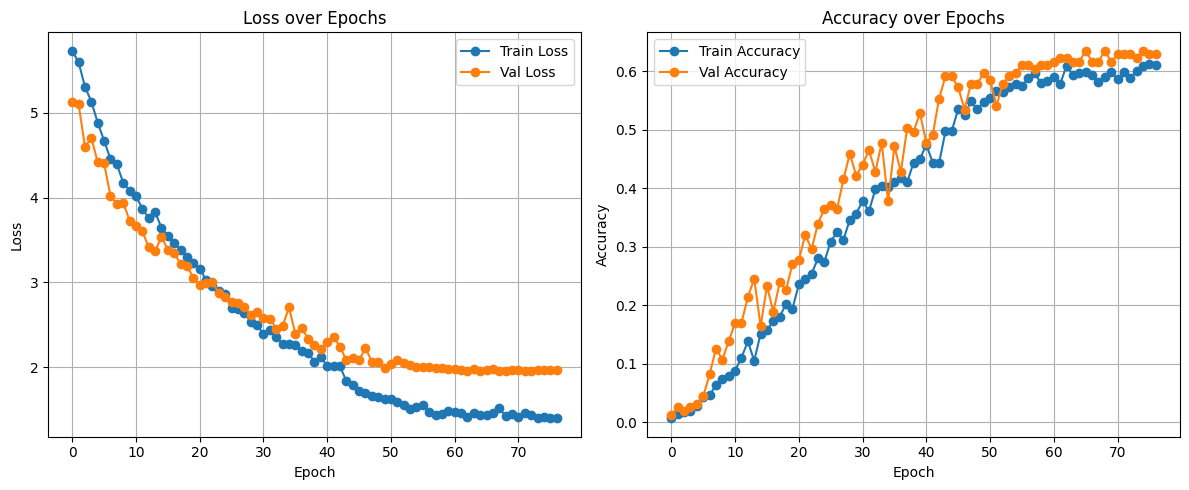

In [3]:
# -----------------------------------------------------------
# 0. 기본 import
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, LayerNormalization, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------
# 1. 전처리 결과 불러오기
X_final = X_xy.copy()
labels_final = y.copy()
num_classes = len(np.unique(labels_final))

# -----------------------------------------------------------
# 2. Train / Val / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, labels_final,
    test_size=0.1, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1, random_state=42, shuffle=True
)

# -----------------------------------------------------------
# 3. class_weight 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# -----------------------------------------------------------
# 4. 모델 정의
seq_len = X_train.shape[1]
feature_dim = X_train.shape[2]

model = Sequential([
    tf.keras.Input(shape=(seq_len, feature_dim)),

    # 시퀀스 전체 regularization
    SpatialDropout1D(0.2),

    Bidirectional(LSTM(96, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.35),

    Bidirectional(LSTM(64, return_sequences=False)),
    LayerNormalization(),
    Dropout(0.35),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -----------------------------------------------------------
# 5. 학습
es = EarlyStopping(
    monitor='val_loss', patience=8,
    restore_best_weights=True
)
rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=16,
    class_weight=class_weights_dict,
    callbacks=[es, rlr],
    verbose=1
)

# -----------------------------------------------------------
# 6. Test 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(" Test Accuracy:", test_acc)
print(" Test Loss:", test_loss)

# -----------------------------------------------------------
# 7. 학습 곡선 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# 1) Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 2) Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
